In [1]:
import PyKDL as kdl
import kdl_parser_py.urdf
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tf
import numpy as np
import copy
import random
from scipy.spatial.transform import Rotation

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

util_path = os.path.abspath("../utils/")
sys.path.append(util_path)
import transformation as trans
import projections as proj
import robot_visualize as rbvis

np.set_printoptions(suppress=True)
%matplotlib widget


In [2]:
urdf_path =  "/home/zfei/code/act-plus-plus/urdf/hitbot_model.urdf"
print("URDF Path: ", urdf_path)
(ok, tree)  = kdl_parser_py.urdf.treeFromFile(urdf_path)
print("kdl_parse urdf ok?: ", ok)
chain = tree.getChain("world", "ee_link")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)


URDF Path:  /home/zfei/code/act-plus-plus/urdf/hitbot_model.urdf
kdl_parse urdf ok?:  True


In [3]:
joint_1_limits = [-0.24, 0] # m, prismatic
joint_2_limits = [-1.57, 1.57] # rad, revolute
joint_3_limits = [-2.861, 0.093] # rad, revolute
joint_4_limits = [-3.1415927, 3.1415927] # rad, revolute


In [4]:
def sample_joints_state():
    # sample joint states
    joint_1 = random.uniform(joint_1_limits[0], joint_1_limits[1])
    joint_2 = random.uniform(joint_2_limits[0], joint_2_limits[1])
    joint_3 = random.uniform(joint_3_limits[0], joint_3_limits[1])
    joint_4 = random.uniform(joint_4_limits[0], joint_4_limits[1])
    joints_state = [joint_1, joint_2, joint_3, joint_4]
    return joints_state

In [5]:
joints_state = sample_joints_state()
print(joints_state)

[-0.09927636571974957, -0.0976140539760415, -2.225183376108844, 1.846814362159328]


In [6]:
joints_states = []
for i in range(100000):
    joints_state = sample_joints_state()
    # joints_state[3] = 0
    joints_states.append(joints_state)
positions, orientations = rbvis.joint_states_to_ee_pose(joints_states, fk_solver)

# quat_to_euler
eulers = []
for quat in orientations:
    euler = Rotation.from_quat(quat).as_euler('xyz', degrees=True)
    eulers.append(euler)
eulers = np.array(eulers)

# only keep the points with yaw angle between -90 and 90
idx = np.where((eulers[:, 2] > -90) & (eulers[:, 2] < 90))[0]
positions = positions[idx]
orientations = orientations[idx]
eulers = eulers[idx]



Text(0, 0.5, 'y (m)')

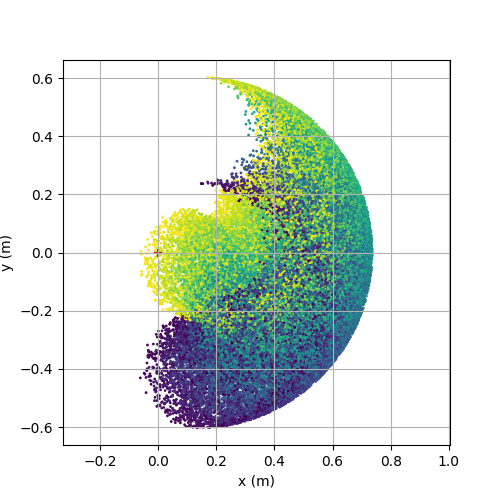

In [7]:
plt.figure(figsize=[5, 5])
plt.scatter(positions[:,0], positions[:,1],c=eulers[:,2], s=1)
plt.scatter(0, 0, c='r', marker='+')
plt.grid()
plt.axis('equal')
plt.xlabel("x (m)")
plt.ylabel("y (m)")

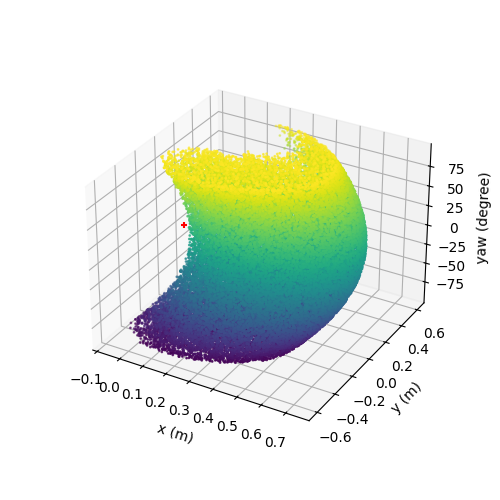

In [8]:
# 3d figure
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], eulers[:,2], c=eulers[:,2], s=1)
ax.scatter(0, 0, 0, c='r', marker='+')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("yaw (degree)")
plt.show()